### 1. 데이터 가져오기

In [2]:
import pandas as    pd
import numpy as np
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # Matplotlib의 폰트 관리 모듈 가져오기

# 한글 폰트를 설정하고 그래프에 한글이 깨지지 않도록 환경을 설정하는 코드
# 사용할 폰트 파일 경로 설정 (여기서는 맑은고딕 폰트 사용)
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_path = r'C:\Windows\Fonts\malgun.ttf'

# 지정한 폰트 파일에서 폰트 이름 추출 (예: 'NanumGothic')
font_name = fm.FontProperties(fname=font_path).get_name()

# Matplotlib의 기본 폰트를 추출한 폰트 이름으로 설정
plt.rcParams['font.family'] = font_name

# 그래프의 기본 폰트 크기를 10으로 설정
plt.rcParams['font.size'] = 10

# 그래프에서 음수 기호('-')가 유니코드로 깨지는 문제 방지
plt.rcParams['axes.unicode_minus'] = False



import seaborn as sns  # 시각화


# 머신러닝을 위한 패키지
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

In [5]:
train_product = pd.read_csv('sample_data/data/product.csv', encoding='utf-8') #상품데이터
train_actions = pd.read_csv('sample_data/data/action.csv', encoding='euc-kr') #사용자 액션

In [7]:
train_product.shape, display(train_product.head()) # head(): 상위 몇 개의 행(기본값: 5개)을 반환

,상품ID,상품명,상품구분
0,1,아이사랑 저축보험,저축|연금
1,2,실버연금,연금|적립|월지급
2,3,내집마련저축,저축|적립
3,4,30일예금,저축|연지급|예금
4,5,희망미래적금,저축|적립|적금


((7, 3), None)

In [8]:
train_actions.shape, display(train_actions.head(10))  # head(): 상위 몇 개의 행(기본값: 5개)을 반환

,사용자ID,상품ID,추천점수,추천일시
0,1,2,3.5,2005-04-02 23:53:47
1,1,3,3.5,2005-04-02 23:31:16
2,1,7,3.5,2005-04-02 23:33:39
3,2,1,5.0,2000-11-21 15:36:54
4,2,2,3.0,2000-11-21 15:29:58
5,2,3,5.0,2000-11-21 15:36:54
6,2,4,5.0,2000-11-21 15:29:58
7,2,5,5.0,2000-11-21 15:36:54
8,2,6,5.0,2000-11-21 15:31:31
9,2,7,5.0,2000-11-21 15:30:59


((55, 4), None)

### 2. 상품 데이터 살펴보기

In [10]:
# 결측치 확인
train_product.isnull().sum()

상품ID    0
상품명     0
상품구분    0
dtype: int64

In [12]:
test = {
    'Product': ['A', 'B', 'A', 'C', 'B'],
    'Price': [100, 200, 100, 300, 200]
}

df = pd.DataFrame(test)

print(df)
print("-" * 50)
print(df.duplicated()) # 각 행의 중복을 확인한다
print("-" * 50)
print(df.duplicated().sum()) # 중복된 행의 개수를 계산

  Product  Price
0       A    100
1       B    200
2       A    100
3       C    300
4       B    200
--------------------------------------------------
0    False
1    False
2     True
3    False
4     True
dtype: bool
--------------------------------------------------
2


In [14]:
# 중복 확인
train_product.duplicated().sum()

0

In [16]:
# 상품구분 Top4 확인
top_product_type = train_product['상품구분'].value_counts().head(4)
top_product_type

상품구분
저축|적립|적금     2
저축|연금        1
연금|적립|월지급    1
저축|적립        1
Name: count, dtype: int64

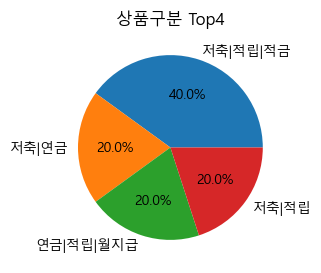

In [17]:
# 원으로 상품구분의 최다 갯수 3개를 그려본다.
plt.figure(figsize=(3, 3)) # 그래프의 크기(단위는 inch) => 가로:3인치, 세로 3인치

"""
파이 차트를 생성하는 함수

x=top_product_type.values: 각 파이 조각의 크기를 결정하는 값(데이터).

labels=top_product_type.index: 각 파이 조각에 표시될 레이블.

autopct='%1.1f%%': 파이 조각 위에 표시할 퍼센트 포맷.
%1.1f%%는 소수점 1자리까지 퍼센트를 표시
"""
plt.pie(top_product_type.values, labels=top_product_type.index, autopct='%1.1f%%')
plt.title('상품구분 Top4')
plt.show()

### 3. 액션데이터 살펴보기

In [19]:
# 결측치 확인
train_actions.isnull().sum()

사용자ID    0
상품ID     0
추천점수     0
추천일시     0
dtype: int64

In [21]:
# 중복 확인
train_actions.duplicated().sum()

0

### 4. 데이터구조 파악

In [22]:
# 상품 데이터
train_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상품ID    7 non-null      int64 
 1   상품명     7 non-null      object
 2   상품구분    7 non-null      object
dtypes: int64(1), object(2)
memory usage: 300.0+ bytes


In [23]:
# 액션 데이터
train_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   사용자ID   55 non-null     int64  
 1   상품ID    55 non-null     int64  
 2   추천점수    55 non-null     float64
 3   추천일시    55 non-null     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.8+ KB


In [24]:
# 기초 통계량 확인
train_actions.describe().T # T를 붙이면 행과 열이 뒤바뀜

,count,mean,std,min,25%,50%,75%,max
사용자ID,55.0,10.927273,6.696750,1.0,4.5,12.0,16.50,22.0
상품ID,55.0,3.618182,2.289193,1.0,1.0,3.0,6.00,7.0
추천점수,55.0,3.727273,1.008382,1.0,3.0,4.0,4.75,5.0


### 5. 데이터 병합

In [25]:
# 상품ID를 기준으로데이터 병합
train_actions_with_name = train_actions.merge(train_product, on='상품ID')

# 미리보기
train_actions_with_name.shape, display(train_actions_with_name.head())

,사용자ID,상품ID,추천점수,추천일시,상품명,상품구분
0,1,2,3.5,2005-04-02 23:53:47,실버연금,연금|적립|월지급
1,1,3,3.5,2005-04-02 23:31:16,내집마련저축,저축|적립
2,1,7,3.5,2005-04-02 23:33:39,MZ미래희망적금,저축|적립|적금
3,2,1,5.0,2000-11-21 15:36:54,아이사랑 저축보험,저축|연금
4,2,2,3.0,2000-11-21 15:29:58,실버연금,연금|적립|월지급


((55, 6), None)